# Logistic Regression with a Trainable Embedding Layer

In [1]:
%matplotlib inline

import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

## Build test and training sets & define preprocessing

In [3]:
NUM_WORDS = 50000
MAXLEN = 1000
NGRAM_RANGE = 1

In [4]:
train, test, preproc = text.texts_from_csv('../data/train.csv',
                                          'cleaned_contents',
                                          label_columns=['Discrimination_Label'],
                                          val_filepath='../data/test.csv',
                                          max_features=NUM_WORDS,
                                          maxlen=MAXLEN,
                                          ngram_range=NGRAM_RANGE)

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 17751
Nrows: 647
647 train sequences
train sequence lengths:
	mean : 1526
	95percentile : 4005
	99percentile : 7619
x_train shape: (647,1000)
y_train shape: (647, 2)
Is Multi-Label? False
162 test sequences
test sequence lengths:
	mean : 1414
	95percentile : 3320
	99percentile : 7203
x_test shape: (162,1000)
y_test shape: (162, 2)


## Define and train the model

In [5]:
model = text.text_classifier('logreg', train, preproc=preproc)
learner = ktrain.get_learner(model, train_data=train, val_data=test)

Is Multi-Label? False
compiling word ID features...
maxlen is 1000
done.


In [6]:
learner.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 2)      100000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 1)      50000       input_1[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 2, 1)         0           embedding_1[0][0]                
                                                                 embedding[0][0]              

### Find a good initial learning rate

This is a method that was developed at the Naval Research Laboratory.  It's been promoted by Jeremy Howard.

simulating training for different learning rates... this may take a few moments...
Train on 647 samples
Epoch 1/5


/usr/local/lib/python3.6/dist-packages/ktrain/core.py:476: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  'If you wish to estimate LR using more epochs, set max_epochs manually.')


647/647 [==============================] - 1s 1ms/sample - loss: 0.8335 - accuracy: 0.4389
Epoch 2/5
647/647 [==============================] - 0s 171us/sample - loss: 0.7879 - accuracy: 0.4590
Epoch 3/5
647/647 [==============================] - 0s 191us/sample - loss: 0.6796 - accuracy: 0.6074
Epoch 4/5
647/647 [==============================] - 0s 168us/sample - loss: 1.0755 - accuracy: 0.7558
Epoch 5/5
 32/647 [>.............................] - ETA: 0s - loss: 31.5179 - accuracy: 0.5938

done.
Visually inspect loss plot and select learning rate associated with falling loss


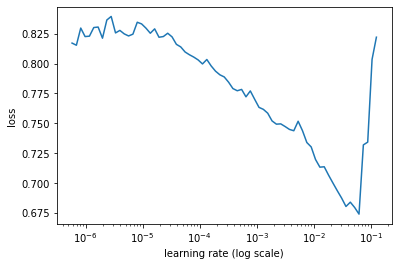

In [7]:
learner.lr_find(show_plot=True)

### Train

In [15]:
learner.autofit(0.01, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.01...
Train on 647 samples, validate on 162 samples
Epoch 1/1024
647/647 [==============================] - 0s 245us/sample - loss: 0.1064 - accuracy: 0.9691 - val_loss: 0.7273 - val_accuracy: 0.7407
Epoch 2/1024
647/647 [==============================] - 0s 236us/sample - loss: 0.0925 - accuracy: 0.9660 - val_loss: 1.0601 - val_accuracy: 0.6728
Epoch 3/1024
608/647 [===========================>..] - ETA: 0s - loss: 0.0954 - accuracy: 0.9622
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.005 (if not early_stopping).
647/647 [==============================] - 0s 219us/sample - loss: 0.0920 - accuracy: 0.9645 - val_loss: 0.9471 - val_accuracy: 0.7037
Epoch 4/1024
647/647 [==============================] - 0s 226us/sample - loss: 0.0577 - accuracy: 0.9907 - val_loss: 0.8473 - val_accuracy: 0.7222
Epoch 5/1024
608/647 [===========================>..] 

## Examine results

In [16]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

           0       0.72      0.58      0.64        65
           1       0.75      0.85      0.80        97

    accuracy                           0.74       162
   macro avg       0.73      0.71      0.72       162
weighted avg       0.74      0.74      0.74       162



array([[38, 27],
       [15, 82]])

## Explain a prediction

In [17]:
import pandas as pd
X_test = pd.read_csv('./data/test.csv')['cleaned_contents']

In [18]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [19]:
predictor.explain('As the perpetrator is the sole breadwinner for his family, I reduce his sentence by two years.')